# A Basis for Grayscale Images
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>
<br />

The concept of "basis" for a vector space is one of the most profound and fruitful ideas in linear algebra. Basis vectors are the "building blocks" that  all other vectors are built from; by "disassembling" a vector into a linear combination of basis elements we are able to "look inside" the vector and highlight many of its relevant features. 

A vector space has an infinite number of bases, but not all bases are created equal; only a carefully crafted basis and, in particular, an orthogonal basis, can show potential in practical applications. In this notebook we will study how a special basis for grayscale images, called the **Haar basis**, can be used to build an efficient compression algorithm that is also robust to errors when used to transmit visual data.

In [1]:
# usual pyton bookkeeping...
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import Image
import math

In [2]:
plt.rcParams["figure.figsize"] = (14,4)
# ensure all images will be grayscale
plt.gray()

<Figure size 1400x400 with 0 Axes>

In [3]:
def multishow(*images):
    fig, axes = plt.subplots(nrows=1, ncols=len(images))
    for i, s in enumerate(images):
        axes[i].matshow(s);
    plt.show()

## 1. The space of MxN matrices

A digital grayscale image of size $M\times N$ consists of $MN$ real values encoding the intensity level of each pixel: the image data can therefore be represented by a real-valued matrix of size $M\times N$.

The set of all matrices of size $M\times N$ forms a vector space if we define addition, scalar multiplication and inner product as:

\begin{align}
\mathbf{A} + \mathbf{B} &=  
    \left[ 
        \begin{array}{ccc} 
            a_{0,0} & \dots & a_{0,N-1} \\ 
            \vdots & & \vdots \\ 
            a_{M-1,0} & \dots & b_{M-1,N-1} 
        \end{array}
    \right]
    + 
    \left[ 
        \begin{array}{ccc} 
            b_{0,0} & \dots & b_{0,N-1} \\ 
            \vdots & & \vdots \\ 
            b_{M-1,0} & \dots & b_{M-1,N-1} 
        \end{array}
    \right]
    =
    \left[ 
        \begin{array}{ccc} 
            a_{0,0}+b_{0,0} & \dots & a_{0,N-1}+b_{0,N-1} \\ 
            \vdots & & \vdots \\ 
            a_{M-1,0}+b_{M-1,0} & \dots & a_{M-1,N-1}+b_{M-1,N-1} 
        \end{array}
    \right]     
    \\ \\ 
\beta\mathbf{A} &=  
    \left[ 
        \begin{array}{ccc} 
            \beta a_{0,0} & \dots & \beta a_{0,N-1} \\ 
            \vdots & & \vdots \\ 
            \beta a_{M-1,0} & \dots & \beta a_{M-1,N-1}
        \end{array}
    \right] 
    \\ \\
    \langle \mathbf{A}, \mathbf{B} \rangle &= \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} a_{m,n} b_{m, n}
\end{align}

In particualr, we have omitted the conjugation operator in the inner product since we will only deal with real-valued matrices. The inner product allows us to define orthogonality between images and this is rather useful since we're going to explore a couple of bases for this space.

Please note that the space of real-valued $M\times N$ matrices is isomorphic to $\mathbb{R}^{MN}$, that is, the space of real-valued Euclidean vectors of size $MN$, since we can always "unroll" a matrix into a vector. Assume we proceed column by column; then the matrix becomes the vector

$$
    \mathbf{a} = \mathbf{A}[:] = [
        \begin{array}{ccccccc}
            a_{0,0} & \dots & a_{M-1,0} & a_{0,1} & \dots & a_{M-1,1} & \ldots & a_{0, N-1} & \dots & a_{M-1,N-1}
        \end{array}]^T
$$

It is easy to see that the vector space operations defined for matrices are consistent with the standard operations in  $\mathbb{R}^{MN}$. Although the matrix and vector forms represent exactly the same data, the matrix form allows us to display the data in the familiar shape of an image. 

## 2. Manipulating and displaying images

In numpy, the equivalence between matrices and images is fully acknowledged. As an example we can create a checkerboard pattern of any size with the following function:

In [4]:
# let's create a checkerboard pattern
SIZE = 4
img = np.zeros((SIZE, SIZE))
for n in range(0, SIZE):
    for m in range(0, SIZE):
        if (n & 0x1) ^ (m & 0x1):
            img[n, m] = 1

and display the matrix with `matshow()`; note that the plotting routine automatically rescales the values in the matrix so that the smallest number is mapped to black and the largest to white.

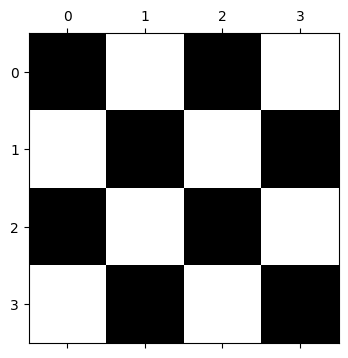

In [5]:
plt.matshow(img); 

Conveniently, using IPython, we can read images from disk in any given format and convert them to numpy arrays; let's load and display for instance a JPEG image:

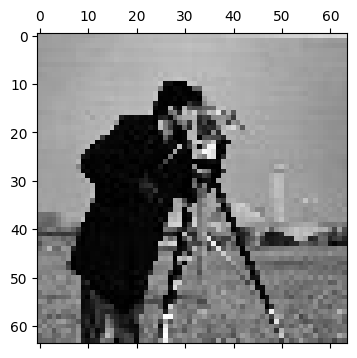

In [6]:
img = np.array(plt.imread('cameraman.jpg'), dtype=int)
plt.matshow(img);

The image is a $64\times 64$ low-resolution version of the famous "cameraman" test picture. Out of curiosity, we can look at the first column of this image, which is is a $64×1$ vector:

In [7]:
img[:,0]

array([156, 157, 157, 152, 154, 155, 151, 157, 152, 155, 158, 159, 159,
       160, 160, 161, 155, 160, 161, 161, 164, 162, 160, 162, 158, 160,
       158, 157, 160, 160, 159, 158, 163, 162, 162, 157, 160, 114, 114,
       103,  88,  62, 109,  82, 108, 128, 138, 140, 136, 128, 122, 137,
       147, 114, 114, 144, 112, 115, 117, 131, 112, 141,  99,  97])

The values are integers between zero and 255, meaning that each pixel is encoded over 8 bits (or 256 gray levels), with zero representing black and 255 representing white.

## 3. The canonical basis for images

The canonical basis for any matrix space $\mathbb{R}^{M\times N}$ is the set of "delta" matrices where only one element is equal to one while all the others are 0. Let's call them $\mathbf{E}_n$ with $0 \leq n < MN$. Here is a function to create the canonical basis vector given its index:

In [8]:
def canonical(n, M=5, N=10):
    e = np.zeros((M, N))
    e[(n % M), int(n / M)] = 1
    return e

Here are some basis vectors: look for the position of white pixel, which differentiates them and note that we enumerate pixels column-wise:

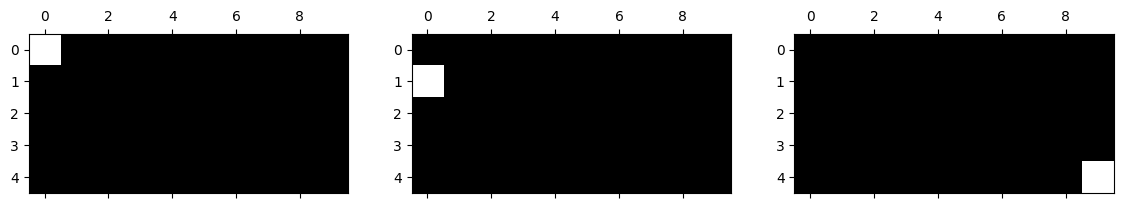

In [9]:
multishow(canonical(0), canonical(1), canonical(49));

## 3. Transmitting images

Suppose we want to transmit the "cameraman" image over a communication channel. The intuitive way to do so is to send the  pixel values one by one, which corresponds to sending the coefficients of the decomposition of the image over the canonical basis. So far, nothing complicated: to send the cameraman image, for instance, we will send $64\times 64 = 4096$ integer values in a row. 

Now suppose that a communication failure takes place after the first half of the pixels have been sent. The received data will allow us to display an approximation of the original image only. If we replace the missing data with zeros, here is what we would see, which is not very pretty:

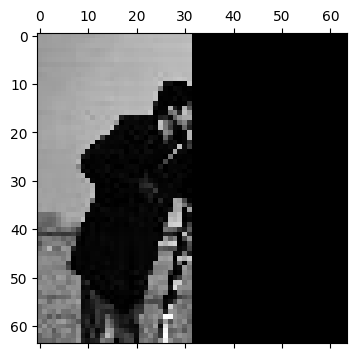

In [10]:
# unrolling of the image for transmission (we go column by column, hence "F")
tx_img = np.ravel(img, "F")

# oops, we lose half the data
tx_img[int(len(tx_img)/2):] = 0

# rebuild matrix
rx_img = np.reshape(tx_img, (64, 64), "F")
plt.matshow(rx_img);

Can we come up with a trasmission scheme that is more robust in the face of channel loss? Interestingly, the answer is yes, and it involves a different, more versatile basis for the space of images. 

### 3.1. The search for a good basis

What we are after is a basis for the space of images that fulfills a set of prerequisites:

 * we want the basis to be orthonormal (or at least orthogonal) so that basis decomposition is obtained simply via a series of inner products
 * we want the basis to be able to represent the image information robustly so that a few, important coefficients will capture most of the image; this will ensure resilence against data loss
 * we want the basis to be easy to compute.

One such basis is the **Haar basis**. While we cannot go into too many details in this notebook, the curious will find a good starting point [here](https://chengtsolin.wordpress.com/2015/04/15/real-time-2d-discrete-wavelet-transform-using-opengl-compute-shader/). Mathematical formulas aside, the Haar basis works by encoding the information in a *hierarchical* way: the first basis vectors encode the broad information and the higher coefficients encode the detail.

First of all, to keep things simple, we will remain in the space of square matrices whose size is a power of two. The code to generate the Haar basis matrices is the following: first we generate a 1D Haar vector and then we obtain the basis matrices by taking the outer product of all possible 1D vectors (don't worry if it's not clear, the results are what's important):

In [11]:
def haar1D(n, SIZE):
    # check power of two
    if math.floor(math.log(SIZE) / math.log(2)) != math.log(SIZE) / math.log(2):
        print("Haar defined only for lengths that are a power of two")
        return None
    if n >= SIZE or n < 0:
        print("invalid Haar index")
        return None
    
    # zero basis vector
    if n == 0:
        return np.ones(SIZE)
    
    # express n > 1 as 2^p + q with p as large as possible;
    # then k = SIZE/2^p is the length of the support
    # and s = qk is the shift
    p = math.floor(math.log(n) / math.log(2))
    pp = int(pow(2, p))
    k = SIZE / pp
    s = (n - pp) * k
    
    h = np.zeros(SIZE)
    h[int(s):int(s+k/2)] = 1
    h[int(s+k/2):int(s+k)] = -1
    # these are not normalized
    return h


def haar2D(n, SIZE=8):
    # get horizontal and vertical indices
    hr = haar1D(n % SIZE, SIZE)
    hv = haar1D(int(n / SIZE), SIZE)
    # 2D Haar basis matrix is separable, so we can
    #  just take the column-row product
    H = np.outer(hr, hv)
    H = H / math.sqrt(np.sum(H * H))
    return H

Let's look at a few basis matrices; note that matrices can have both positive and negative values, so that positive values will be white, negative values will be black and the value of zero will be represented as gray:

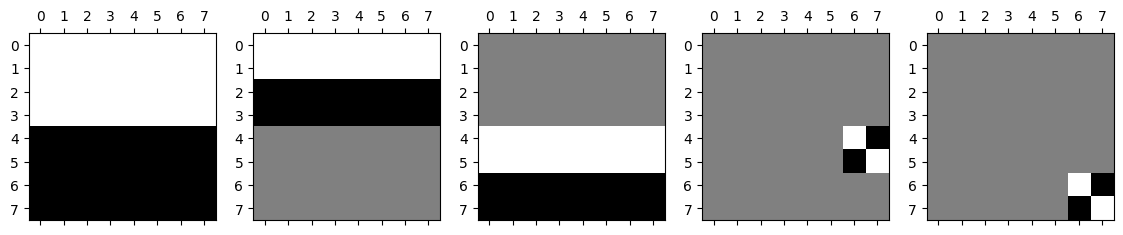

In [12]:
multishow(haar2D(1), haar2D(2), haar2D(3), haar2D(62), haar2D(63));

We can notice two key properties

* each basis matrix has positive and negative values in some symmetric pattern: this means that the basis matrix will implicitly compute the difference between image areas
* low-index basis matrices take differences between large areas, while high-index ones take differences in smaller **localized** areas of the image

We can immediately verify that the Haar matrices are orthogonal:

In [13]:
# let's use an 8x8 space; there will be 64 basis vectors
# compute all possible inner product and only print the nonzero results
for m in range(0,64):
    for n in range(0,64):
        r = np.sum(haar2D(m, 8) * haar2D(n, 8))
        if r != 0:
            print("[%dx%d -> %f] " % (m, n, r), end="")

[0x0 -> 1.000000] [1x1 -> 1.000000] [2x2 -> 1.000000] [3x3 -> 1.000000] [4x4 -> 1.000000] [5x5 -> 1.000000] [6x6 -> 1.000000] [7x7 -> 1.000000] [8x8 -> 1.000000] [9x9 -> 1.000000] [10x10 -> 1.000000] [11x11 -> 1.000000] [12x12 -> 1.000000] [13x13 -> 1.000000] [14x14 -> 1.000000] [15x15 -> 1.000000] [16x16 -> 1.000000] [16x17 -> -0.000000] [17x16 -> -0.000000] [17x17 -> 1.000000] [18x18 -> 1.000000] [19x19 -> 1.000000] [20x20 -> 1.000000] [21x21 -> 1.000000] [22x22 -> 1.000000] [23x23 -> 1.000000] [24x24 -> 1.000000] [24x25 -> -0.000000] [25x24 -> -0.000000] [25x25 -> 1.000000] [26x26 -> 1.000000] [27x27 -> 1.000000] [28x28 -> 1.000000] [29x29 -> 1.000000] [30x30 -> 1.000000] [31x31 -> 1.000000] [32x32 -> 1.000000] [33x33 -> 1.000000] [34x34 -> 1.000000] [35x35 -> 1.000000] [36x36 -> 1.000000] [37x37 -> 1.000000] [38x38 -> 1.000000] [39x39 -> 1.000000] [40x40 -> 1.000000] [41x41 -> 1.000000] [42x42 -> 1.000000] [43x43 -> 1.000000] [44x44 -> 1.000000] [45x45 -> 1.000000] [46x46 -> 1.0000

### 3.3. Haar image decomposition

Although we know it from the properties of orthogonal bases, let us verify that we can decompose the Cameraman image onto the Haar basis and reconstruct it:

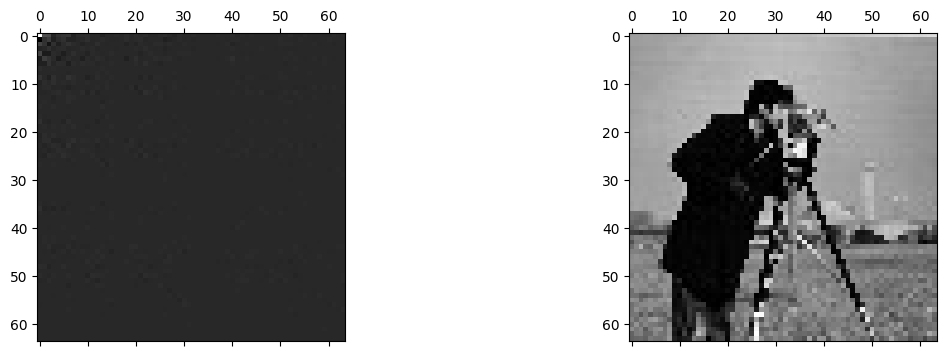

In [14]:
# project the image onto the Haar basis, obtaining a vector of 4096 coefficients
# this is simply the analysis formula for the vector space with an orthogonal basis
tx_img = np.zeros(64*64)
for k in range(0, (64*64)):
    tx_img[k] = np.sum(img * haar2D(k, 64))

# now rebuild the image with the synthesis formula; since the basis is orthonormal
#  we just need to scale the basis matrices by the projection coefficients
rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += tx_img[k] * haar2D(k, 64)

multishow(tx_img.reshape(64,64), rx_img);

As you can see, the set of Haar coefficients do not make much sense visually, but the decomposition works! 

### 3.3. Transmission error with the Haar decomposition

Now let's see what happens if, like before, we lose the second half of the coefficients:

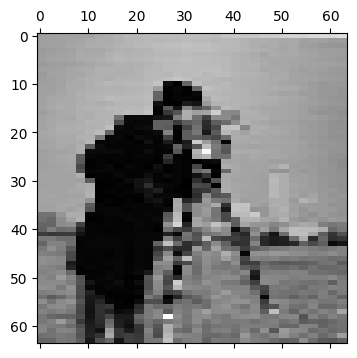

In [15]:
# oops, we lose half the data
lossy_img = np.copy(tx_img);
lossy_img[int(len(tx_img)/2):] = 0

# rebuild matrix
rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += lossy_img[k] * haar2D(k, 64)

plt.matshow(rx_img);

That's quite remarkable, no? We've lost the same amount of information as before but the image is still acceptable. This is because we lost the coefficients associated to the fine details of the image but we retained the "broad strokes" encoded by the first half. 

Note that if we lose the first half of the coefficients the result is markedly different:

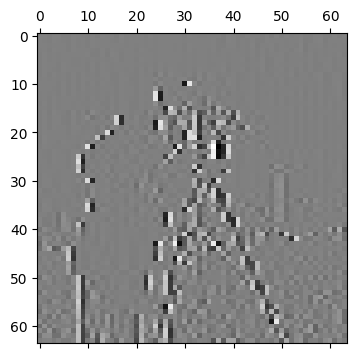

In [16]:
lossy_img = np.copy(tx_img);
lossy_img[0:int(len(tx_img)/2)] = 0

rx_img = np.zeros((64, 64))
for k in range(0, (64*64)):
    rx_img += lossy_img[k] * haar2D(k, 64)

plt.matshow(rx_img);

In fact, schemes like this one are used in *progressive encoding*: send the most important information first and add details if the channel permits it. You may have experienced this while browsing the interned over a slow connection. 

All in all, a great application of a change of basis!

# ---------------------------------




### Did you like this Notebook?
Yes, no, maybe? Why don't you give us some feedback using the completely anonymous form below? Thank you!

In [17]:
from IPython.display import IFrame
IFrame('https://www.surveymonkey.com/r/NOTOSURVEY?notebook_set=COM303&notebook_id=ImageHaarBasis', 600, 800)